In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPool2D, Flatten
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.examples.tutorials.mnist import input_data as mnistoriginal
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [2]:
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

In [5]:
train = pd.read_csv('../../data/mnist_data/train.csv')
test = pd.read_csv('../../data/mnist_data/test.csv')

In [6]:
x_train = train.drop('label',axis=1)
y_train = train['label']

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

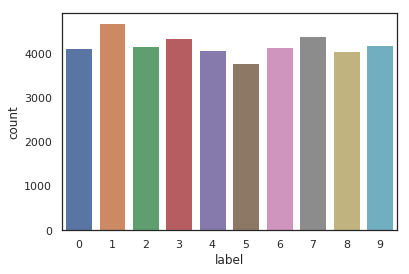

In [7]:
g = sns.countplot(y_train)

y_train.value_counts()

In [8]:
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [10]:
x_train = x_train/255
test = test/255

In [11]:
x_train = x_train.values.reshape(-1, 28,28,1)
test = test.values.reshape(-1, 28,28,1)
y_train = to_categorical(y_train)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=30)

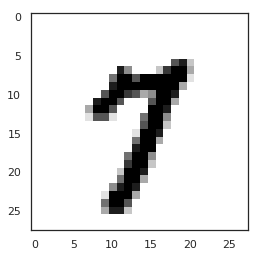

In [13]:
plt.imshow(x_train[0][:,:,0], cmap='gray_r')

In [14]:
model = Sequential()

model.add(Conv2D(filters= 32, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters= 32, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters= 64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters= 64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(1536, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [16]:
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
lr_reducer = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [18]:
epochs = 50
batch_size = 64

In [19]:
idatagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

idatagen.fit(x_train)

In [20]:
history = parallel_model.fit_generator(idatagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(x_val, y_val), verbose=2, steps_per_epoch=x_train.shape[0]//batch_size, callbacks=[lr_reducer])

Epoch 1/50
 - 21s - loss: 0.2530 - acc: 0.9174 - val_loss: 0.1054 - val_acc: 0.9648
Epoch 2/50
 - 10s - loss: 0.0847 - acc: 0.9746 - val_loss: 0.0429 - val_acc: 0.9876
Epoch 3/50
 - 10s - loss: 0.0636 - acc: 0.9804 - val_loss: 0.0320 - val_acc: 0.9905
Epoch 4/50
 - 10s - loss: 0.0534 - acc: 0.9838 - val_loss: 0.0351 - val_acc: 0.9907
Epoch 5/50
 - 10s - loss: 0.0499 - acc: 0.9851 - val_loss: 0.0257 - val_acc: 0.9933
Epoch 6/50
 - 9s - loss: 0.0449 - acc: 0.9862 - val_loss: 0.0325 - val_acc: 0.9907
Epoch 7/50
 - 9s - loss: 0.0442 - acc: 0.9871 - val_loss: 0.0305 - val_acc: 0.9907

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/50
 - 9s - loss: 0.0265 - acc: 0.9917 - val_loss: 0.0222 - val_acc: 0.9924
Epoch 9/50
 - 9s - loss: 0.0236 - acc: 0.9931 - val_loss: 0.0268 - val_acc: 0.9924

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 10/50
 - 9s - loss: 0.0161 - acc: 0.9947 - val_loss: 0.0191 - val_acc: 0.9940
Ep

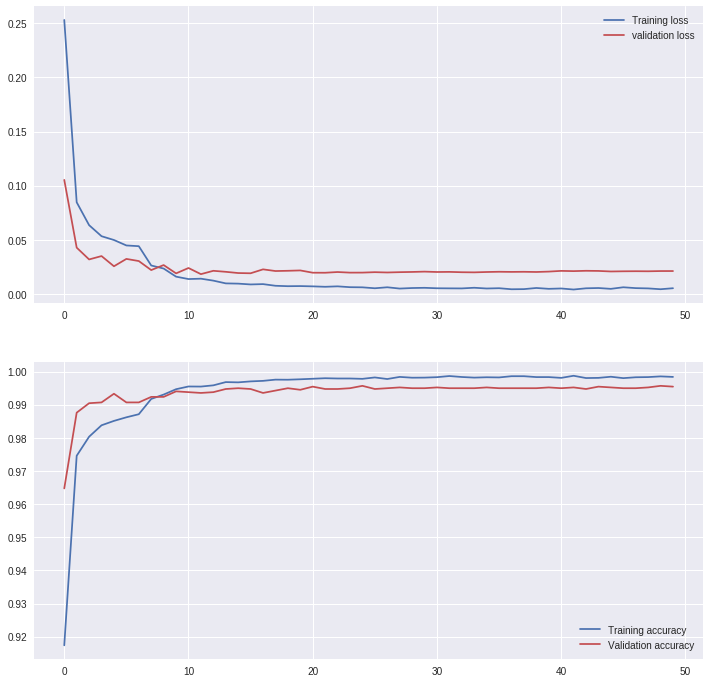

In [21]:
plt.style.use('seaborn')
fig, ax = plt.subplots(2,1, figsize=(12,12))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

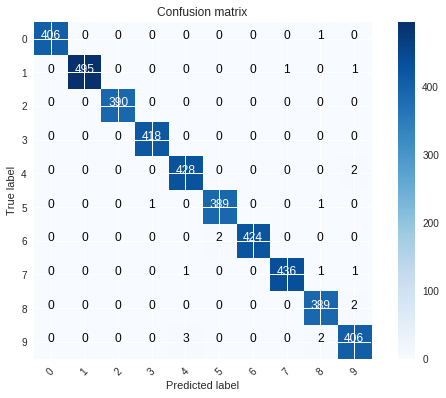

In [23]:
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_val, axis=1)
cmat = confusion_matrix(y_true_class, y_pred_class)
plot_confusion_matrix(cmat, classes=range(10))

In [24]:
errors = y_pred_class - y_true_class != 0

In [25]:
x_val_error = x_val[errors]
y_true_error = y_true_class[errors]
y_pred_error = y_pred_class[errors]
y_pred_prob_error = np.max(y_pred[errors], axis=1)

In [27]:
df = pd.DataFrame({'true' : y_true_error, 'pred' : y_pred_error, 'prob': y_pred_prob_error})

In [28]:
df_sorted = df.sort_values(by='prob', ascending=False)

In [29]:
def plot_errored(n, img, true, pred, prob):
    img = img.reshape((28, 28))
    ax[n].imshow(img, cmap="gray_r")
    ax[n].set_title('pred : {}\n True:{}'.format(true, pred))

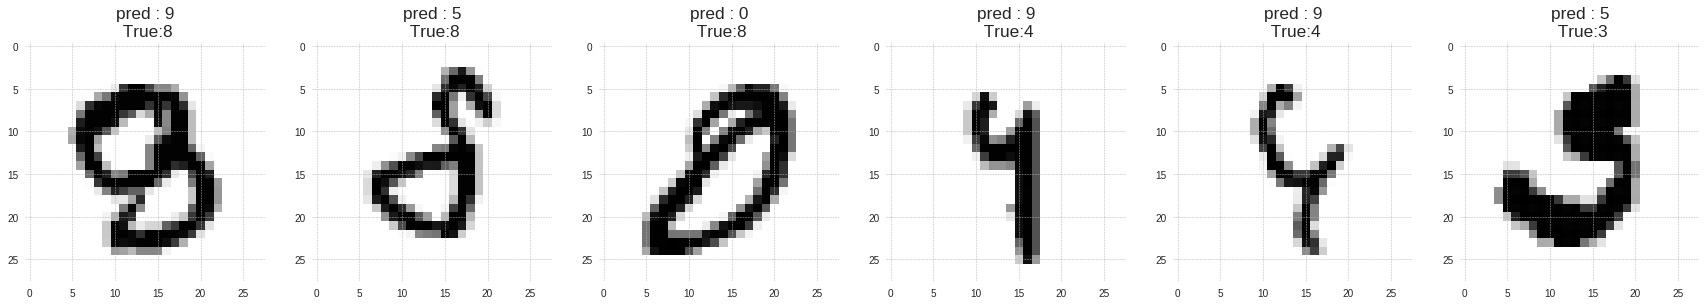

In [30]:
plt.style.use('bmh')
fig, ax = plt.subplots(1,6, figsize=(30,30))
n = 0
for x in df_sorted.index[:6]:
    plot_errored(n, x_val_error[x], df_sorted.true[x], df_sorted.pred[x], df_sorted.prob[x])
    n +=1

true 6
predicted  5


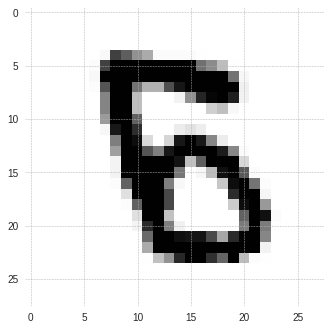

In [31]:
idx = 10
print( "true", y_true_error[idx])
print( "predicted ", y_pred_error[idx])
plt.imshow(x_val_error[idx].reshape(28,28))

In [32]:
result = model.predict(test)
result = np.argmax(result, axis=1)
imageid = range(1,len(result)+1)

In [34]:
submission = pd.DataFrame({'ImageId':imageid, 'Label':result})

In [35]:
submission.to_csv("submission.csv", index=False)